# 1. **Installing**


In [18]:
%pip install torch torchvision matplotlib

# 2. **Datasets**

In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# For more datasets
# https://pytorch.org/vision/stable/datasets.html

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

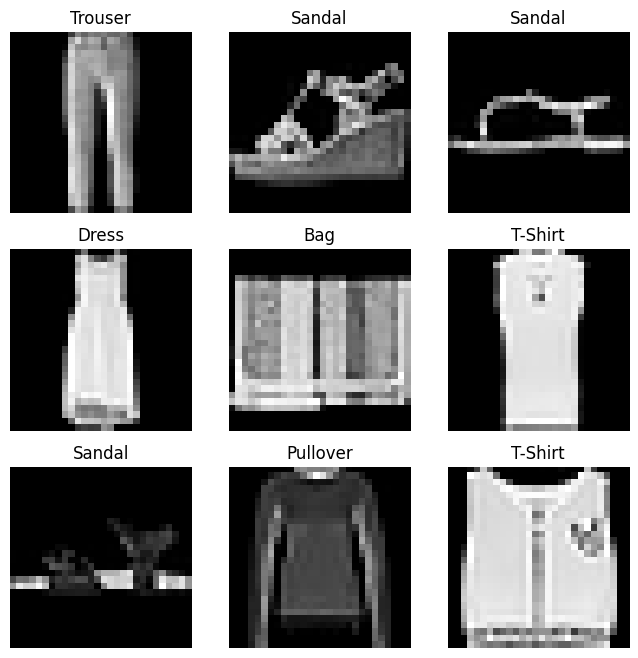

In [20]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 3. **Dataloaders**

The Dataset is passed as an argument to DataLoader. This wraps an iterable over our dataset, and supports `automatic batching`, `sampling`, `shuffling` and `multiprocess data loading`. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# 4. **Models**

To define a neural network in PyTorch, we create a class that inherits from `nn.Module`. We define the layers of the network in the `__init__` function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the `GPU` or `MPS` if available.

In [7]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# 5. **Loss function and Optimizer**

The `loss function` measures the difference between the predicted output of the neural network and the actual output and with that in effect how accurate the prediction was.

Optimization is the process of adjusting model parameters to reduce model error in each training step. An `optimizer` is an object that will hold the current state and will update the parameters based on the computed gradients.

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# 6. **Train and Test methods**

In the `train` method the model makes predictions on the training dataset (fed to it in batches), and `backpropagates` the prediction error to adjust the model's parameters.

In the `test` method the model's performance is checked against the test dataset to ensure that it is learning.

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# 7. **Training the model**

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301758  [   64/60000]
loss: 2.282542  [ 6464/60000]
loss: 2.267558  [12864/60000]
loss: 2.264923  [19264/60000]
loss: 2.236611  [25664/60000]
loss: 2.229199  [32064/60000]
loss: 2.231968  [38464/60000]
loss: 2.203656  [44864/60000]
loss: 2.202980  [51264/60000]
loss: 2.163382  [57664/60000]
Test Error: 
 Accuracy: 42.8%, Avg loss: 2.157632 

Epoch 2
-------------------------------
loss: 2.171131  [   64/60000]
loss: 2.154080  [ 6464/60000]
loss: 2.099858  [12864/60000]
loss: 2.114776  [19264/60000]
loss: 2.058622  [25664/60000]
loss: 2.015683  [32064/60000]
loss: 2.038721  [38464/60000]
loss: 1.960779  [44864/60000]
loss: 1.973375  [51264/60000]
loss: 1.891796  [57664/60000]
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.890166 

Epoch 3
-------------------------------
loss: 1.925997  [   64/60000]
loss: 1.889691  [ 6464/60000]
loss: 1.773795  [12864/60000]
loss: 1.811655  [19264/60000]
loss: 1.701951  [25664/60000]
loss: 1.658380  [32064/600

# 8. **Saving the model**

In [11]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


#9. **Loading the model**

In [12]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

#10. **Predicting with the model**

In [13]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
